In [1]:
from pydub.utils import which
from pydub import AudioSegment
AudioSegment.converter = which("ffmpeg")  # Use the path from CMD

from pydub.silence import split_on_silence
import noisereduce as nr
import numpy as np
import pandas as pd
import sklearn as sk
from IPython.display import Audio

import keras
import tensorflow
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as mp
import os
import sys
import seaborn as sns
from scipy.io import wavfile


DATA PROCESSING

In [3]:
dataset="D:\intern code aloha\ml\car\havenv\Emotional Speech Dataset (ESD)\Emotion Speech Dataset"
speech_directory_list = os.listdir(dataset)
actor_emotion_map={}
for actor in speech_directory_list:
    actor_path = os.path.join(dataset, actor)
    if os.path.isdir(actor_path):
        emotions = {}
        for emotion in os.listdir(actor_path):
            emotion_path = os.path.join(actor_path, emotion)
            if os.path.isdir(emotion_path):
                files = os.listdir(emotion_path)
                emotions[emotion] = files
        actor_emotion_map[actor] = emotions
print(type(actor_emotion_map))
df=pd.DataFrame(actor_emotion_map)





<class 'dict'>


In [4]:
df.shape
df.columns

Index(['0001', '0002', '0005', '0006', '0007', '0008', '0009', '0010', '0011',
       '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019', '0020'],
      dtype='object')

In [5]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, Angry to Surprise
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0001    5 non-null      object
 1   0002    5 non-null      object
 2   0005    4 non-null      object
 3   0006    5 non-null      object
 4   0007    5 non-null      object
 5   0008    5 non-null      object
 6   0009    5 non-null      object
 7   0010    5 non-null      object
 8   0011    5 non-null      object
 9   0012    5 non-null      object
 10  0013    5 non-null      object
 11  0014    5 non-null      object
 12  0015    5 non-null      object
 13  0016    5 non-null      object
 14  0017    5 non-null      object
 15  0018    5 non-null      object
 16  0019    5 non-null      object
 17  0020    5 non-null      object
dtypes: object(18)
memory usage: 760.0+ bytes
None
                                                     0001  \
count                                                   5   


In [6]:

df.head()
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.columns=df.columns.str.strip()
df.index=df.index.str.strip()
df.dtypes
row_file_count = df.iloc[0].apply(len).sum()
print(type(df.iloc[1,1][0]))

<class 'str'>


In [7]:
df.index.name='emotions'
df.columns.name='actors'
actors=df.columns.tolist()
emos=df.index.tolist()

In [8]:
def standardize_audio_to_array(input_path):
    audio = AudioSegment.from_file(input_path)
    audio = audio.set_channels(1).set_frame_rate(16000).set_sample_width(2)
    audio = audio.apply_gain(-20 - audio.dBFS)
    chunks = split_on_silence(audio, min_silence_len=2000, silence_thresh=-40)
    processed = AudioSegment.empty()
    for chunk in chunks:
        processed += chunk.append(AudioSegment.silent(duration=500), crossfade=0)
    samples = np.array(processed.get_array_of_samples())
    rate = processed.frame_rate
    return rate, samples

def enhance_and_save(rate, data, output_path):
    cleaned = nr.reduce_noise(y=data.astype(np.float32), sr=rate, stationary=True)
    cleaned = cleaned / np.max(np.abs(cleaned))
    cleaned_int16 = (cleaned * 32767).astype(np.int16)
    wavfile.write(output_path, rate, cleaned_int16)
    return output_path

def segment_audio(input_path, segment_length=30000):
    audio = AudioSegment.from_file(input_path)
    return [audio[i * segment_length:(i + 1) * segment_length] for i in range(len(audio) // segment_length)]

In [9]:
bad_files = []
processed_files = []  # 🔁 Collect all successfully processed files
import traceback
for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        file_list = df.iat[i, j]
        if isinstance(file_list, list):
            for file_name in file_list:
                full_path = os.path.join(dataset, actors[j], emos[i], file_name)
                final_path = full_path.replace(".wav", "_processed.wav")
                try:
                    print(f"🔄 Processing: {full_path}")
                    rate, standardized = standardize_audio_to_array(full_path)
                    enhance_and_save(rate, standardized, final_path)
                    processed_files.append(final_path)  # ✅ Store path
                    # Optional: segment
                    # segments = segment_audio(final_path)
                    # for idx, seg in enumerate(segments):
                    #     seg.export(final_path.replace(".wav", f"_seg{idx}.wav"), format="wav")
                except Exception as e:
                    print(f"❌ Error processing {full_path}: {e}")
                    traceback.print_exc()
                    bad_files.append(full_path)

# Summary
print(f"\n✅ Total processed files: {len(processed_files)}")
print(f"🚫 Total bad files: {len(bad_files)}")

🔄 Processing: D:\intern code aloha\ml\car\havenv\Emotional Speech Dataset (ESD)\Emotion Speech Dataset\0001\Angry\0001_000351.wav
🔄 Processing: D:\intern code aloha\ml\car\havenv\Emotional Speech Dataset (ESD)\Emotion Speech Dataset\0001\Angry\0001_000352.wav
🔄 Processing: D:\intern code aloha\ml\car\havenv\Emotional Speech Dataset (ESD)\Emotion Speech Dataset\0001\Angry\0001_000353.wav
🔄 Processing: D:\intern code aloha\ml\car\havenv\Emotional Speech Dataset (ESD)\Emotion Speech Dataset\0001\Angry\0001_000354.wav
🔄 Processing: D:\intern code aloha\ml\car\havenv\Emotional Speech Dataset (ESD)\Emotion Speech Dataset\0001\Angry\0001_000355.wav
🔄 Processing: D:\intern code aloha\ml\car\havenv\Emotional Speech Dataset (ESD)\Emotion Speech Dataset\0001\Angry\0001_000356.wav
🔄 Processing: D:\intern code aloha\ml\car\havenv\Emotional Speech Dataset (ESD)\Emotion Speech Dataset\0001\Angry\0001_000357.wav
🔄 Processing: D:\intern code aloha\ml\car\havenv\Emotional Speech Dataset (ESD)\Emotion Sp

Traceback (most recent call last):
  File "C:\Users\kavik\AppData\Local\Temp\ipykernel_2288\1135352274.py", line 13, in <module>
    rate, standardized = standardize_audio_to_array(full_path)
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kavik\AppData\Local\Temp\ipykernel_2288\3164425700.py", line 2, in standardize_audio_to_array
    audio = AudioSegment.from_file(input_path)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\intern code aloha\ml\car\havenv\Lib\site-packages\pydub\audio_segment.py", line 773, in from_file
    raise CouldntDecodeError(
pydub.exceptions.CouldntDecodeError: Decoding failed. ffmpeg returned error code: 3199971767

Output from ffmpeg/avlib:

ffmpeg version 7.1.1-essentials_build-www.gyan.dev Copyright (c) 2000-2025 the FFmpeg developers
  built with gcc 14.2.0 (Rev1, Built by MSYS2 project)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --

🔄 Processing: D:\intern code aloha\ml\car\havenv\Emotional Speech Dataset (ESD)\Emotion Speech Dataset\0019\Happy\0019_000701.wav
🔄 Processing: D:\intern code aloha\ml\car\havenv\Emotional Speech Dataset (ESD)\Emotion Speech Dataset\0019\Happy\0019_000702.wav
🔄 Processing: D:\intern code aloha\ml\car\havenv\Emotional Speech Dataset (ESD)\Emotion Speech Dataset\0019\Happy\0019_000703.wav
🔄 Processing: D:\intern code aloha\ml\car\havenv\Emotional Speech Dataset (ESD)\Emotion Speech Dataset\0019\Happy\0019_000704.wav
🔄 Processing: D:\intern code aloha\ml\car\havenv\Emotional Speech Dataset (ESD)\Emotion Speech Dataset\0019\Happy\0019_000705.wav
🔄 Processing: D:\intern code aloha\ml\car\havenv\Emotional Speech Dataset (ESD)\Emotion Speech Dataset\0019\Happy\0019_000706.wav
🔄 Processing: D:\intern code aloha\ml\car\havenv\Emotional Speech Dataset (ESD)\Emotion Speech Dataset\0019\Happy\0019_000707.wav
🔄 Processing: D:\intern code aloha\ml\car\havenv\Emotional Speech Dataset (ESD)\Emotion Sp

Traceback (most recent call last):
  File "C:\Users\kavik\AppData\Local\Temp\ipykernel_2288\1135352274.py", line 13, in <module>
    rate, standardized = standardize_audio_to_array(full_path)
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kavik\AppData\Local\Temp\ipykernel_2288\3164425700.py", line 2, in standardize_audio_to_array
    audio = AudioSegment.from_file(input_path)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\intern code aloha\ml\car\havenv\Lib\site-packages\pydub\audio_segment.py", line 773, in from_file
    raise CouldntDecodeError(
pydub.exceptions.CouldntDecodeError: Decoding failed. ffmpeg returned error code: 3199971767

Output from ffmpeg/avlib:

ffmpeg version 7.1.1-essentials_build-www.gyan.dev Copyright (c) 2000-2025 the FFmpeg developers
  built with gcc 14.2.0 (Rev1, Built by MSYS2 project)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --

🔄 Processing: D:\intern code aloha\ml\car\havenv\Emotional Speech Dataset (ESD)\Emotion Speech Dataset\0016\Sad\0016_001052.wav
🔄 Processing: D:\intern code aloha\ml\car\havenv\Emotional Speech Dataset (ESD)\Emotion Speech Dataset\0016\Sad\0016_001053.wav
🔄 Processing: D:\intern code aloha\ml\car\havenv\Emotional Speech Dataset (ESD)\Emotion Speech Dataset\0016\Sad\0016_001054.wav
🔄 Processing: D:\intern code aloha\ml\car\havenv\Emotional Speech Dataset (ESD)\Emotion Speech Dataset\0016\Sad\0016_001055.wav
🔄 Processing: D:\intern code aloha\ml\car\havenv\Emotional Speech Dataset (ESD)\Emotion Speech Dataset\0016\Sad\0016_001056.wav
🔄 Processing: D:\intern code aloha\ml\car\havenv\Emotional Speech Dataset (ESD)\Emotion Speech Dataset\0016\Sad\0016_001057.wav
🔄 Processing: D:\intern code aloha\ml\car\havenv\Emotional Speech Dataset (ESD)\Emotion Speech Dataset\0016\Sad\0016_001058.wav
🔄 Processing: D:\intern code aloha\ml\car\havenv\Emotional Speech Dataset (ESD)\Emotion Speech Dataset\0

In [42]:
print(type(processed_files))
processed_audio={}
Angry = []
Happy = []
Neutral = []
Sad = []
Surprise = []
for path in processed_files:
    if(path.split('\\')[8]=='Angry'):
        Angry.append(path)
    if(path.split('\\')[8]=='Happy'):
        Happy.append(path)
    if(path.split('\\')[8]=='Sad'):
        Sad.append(path)
    if(path.split('\\')[8]=='Neutral'):
        Neutral.append(path)
    if(path.split('\\')[8]=='Surprise'):
        Surprise.append(path)
print(len(Happy),len(Angry),len(Sad),len(Neutral),len(Surprise))
def pad_with_nan(lst, desired_length):
    return lst + [float('nan')] * (desired_length - len(lst))
Happy=pad_with_nan(Happy,6300)
Sad=pad_with_nan(Sad,6300)
processed_audio={'Angry':Angry,'Happy':Happy,'Sad':Sad,'Surprise':Surprise,'Neutral':Neutral}
print(len(Happy),len(Angry),len(Sad),len(Neutral),len(Surprise))



<class 'list'>
5950 6300 6197 6300 6300
6300 6300 6300 6300 6300


In [72]:
dff=pd.DataFrame(processed_audio)
dff.shape
dff=dff.transpose()
dff=dff.ffill()
dff.head(5)




0     \
Angry     D:\intern code aloha\ml\car\havenv\Emotional S...   
Happy     D:\intern code aloha\ml\car\havenv\Emotional S...   
Sad       D:\intern code aloha\ml\car\havenv\Emotional S...   
Surprise  D:\intern code aloha\ml\car\havenv\Emotional S...   
Neutral   D:\intern code aloha\ml\car\havenv\Emotional S...   

                                                       1     \
Angry     D:\intern code aloha\ml\car\havenv\Emotional S...   
Happy     D:\intern code aloha\ml\car\havenv\Emotional S...   
Sad       D:\intern code aloha\ml\car\havenv\Emotional S...   
Surprise  D:\intern code aloha\ml\car\havenv\Emotional S...   
Neutral   D:\intern code aloha\ml\car\havenv\Emotional S...   

                                                       2     \
Angry     D:\intern code aloha\ml\car\havenv\Emotional S...   
Happy     D:\intern code aloha\ml\car\havenv\Emotional S...   
Sad       D:\intern code aloha\ml\car\havenv\Emotional S...   
Surprise  D:\intern code aloha\ml\car\havenv\Emotional S...   
Neutral   D:\intern code aloha\ml\car\havenv\Emotional S...   

                                                       3     \
Angry     D:\intern code aloha\ml\car\havenv\Emotional S...   
Happy     D:\intern code aloha\ml\car\havenv\Emotional S...   
Sad       D:\intern code aloha\ml\car\havenv\Emotional S...   
Surprise  D:\intern code aloha\ml\car\havenv\Emotional S...   
Neutral   D:\intern code aloha\ml\car\havenv\Emotional S...   

                                                       4     \
Angry     D:\intern code aloha\ml\car\havenv\Emotional S...   
Happy     D:\intern code aloha\ml\car\havenv\Emotional S...   
Sad       D:\intern code aloha\ml\car\havenv\Emotional S...   
Surprise  D:\intern code aloha\ml\car\havenv\Emotional S...   
Neutral   D:\intern code aloha\ml\car\havenv\Emotional S...   

                                                       5     \
Angry     D:\intern code aloha\ml\car\havenv\Emotional S...   
Happy     D:\intern code aloha\ml\car\havenv\Emotional S...   
Sad       D:\intern code aloha\ml\car\havenv\Emotional S...   
Surprise  D:\intern code aloha\ml\car\havenv\Emotional S...   
Neutral   D:\intern code aloha\ml\car\havenv\Emotional S...   

                                                       6     \
Angry     D:\intern code aloha\ml\car\havenv\Emotional S...   
Happy     D:\intern code aloha\ml\car\havenv\Emotional S...   
Sad       D:\intern code aloha\ml\car\havenv\Emotional S...   
Surprise  D:\intern code aloha\ml\car\havenv\Emotional S...   
Neutral   D:\intern code aloha\ml\car\havenv\Emotional S...   

                                                       7     \
Angry     D:\intern code aloha\ml\car\havenv\Emotional S...   
Happy     D:\intern code aloha\ml\car\havenv\Emotional S...   
Sad       D:\intern code aloha\ml\car\havenv\Emotional S...   
Surprise  D:\intern code aloha\ml\car\havenv\Emotional S...   
Neutral   D:\intern code aloha\ml\car\havenv\Emotional S...   

                                                       8     \
Angry     D:\intern code aloha\ml\car\havenv\Emotional S...   
Happy     D:\intern code aloha\ml\car\havenv\Emotional S...   
Sad       D:\intern code aloha\ml\car\havenv\Emotional S...   
Surprise  D:\intern code aloha\ml\car\havenv\Emotional S...   
Neutral   D:\intern code aloha\ml\car\havenv\Emotional S...   

                                                       9     ...  \
Angry     D:\intern code aloha\ml\car\havenv\Emotional S...  ...   
Happy     D:\intern code aloha\ml\car\havenv\Emotional S...  ...   
Sad       D:\intern code aloha\ml\car\havenv\Emotional S...  ...   
Surprise  D:\intern code aloha\ml\car\havenv\Emotional S...  ...   
Neutral   D:\intern code aloha\ml\car\havenv\Emotional S...  ...   

                                                       6290  \
Angry     D:\intern code aloha\ml\car\havenv\Emotional S...   
Happy     D:\intern code aloha\ml\car\havenv\Emotional S...   
Sad       D:\intern code aloha\ml\car\havenv\E

DATA VISUALISATION:

In [68]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio

def create_waveplot(data, sr, emotion, idx):
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(data, sr=sr)
    plt.title(f'Waveplot - {emotion} - Sample {idx}')
    plt.tight_layout()
    plt.show()

def create_spectrogram(data, sr, emotion, idx):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(10, 3))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.title(f'Spectrogram - {emotion} - Sample {idx}')
    plt.tight_layout()
    plt.show()


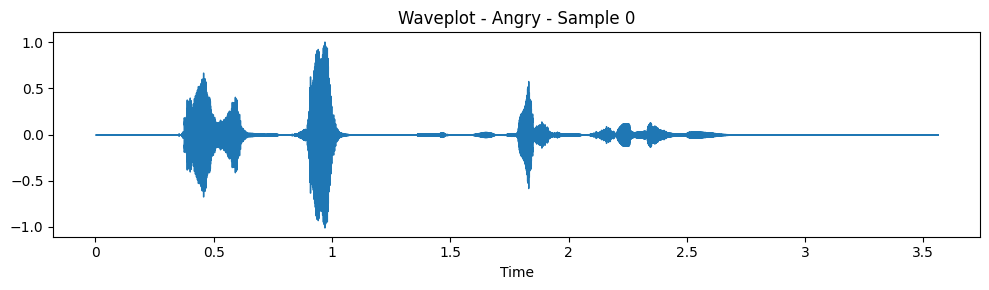

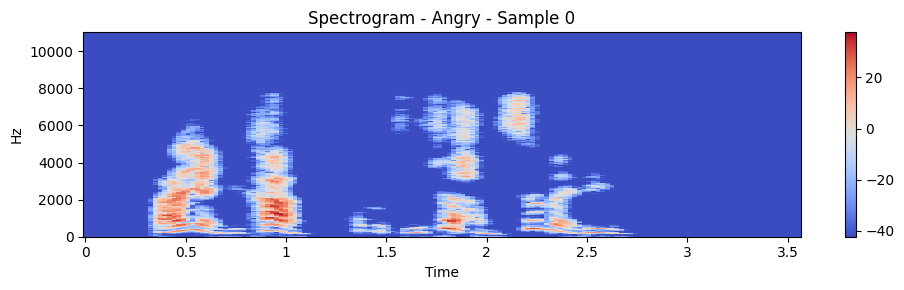

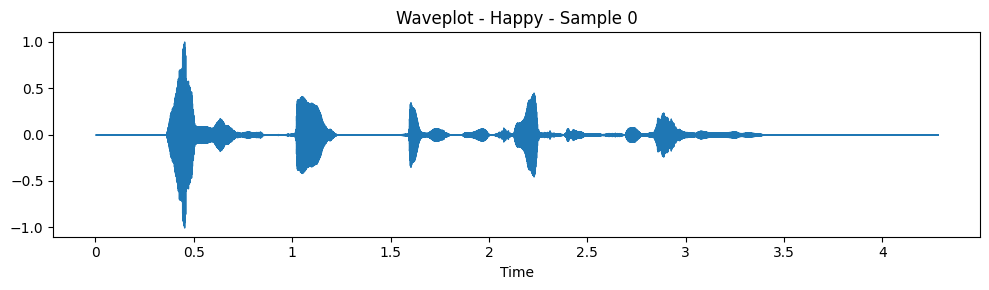

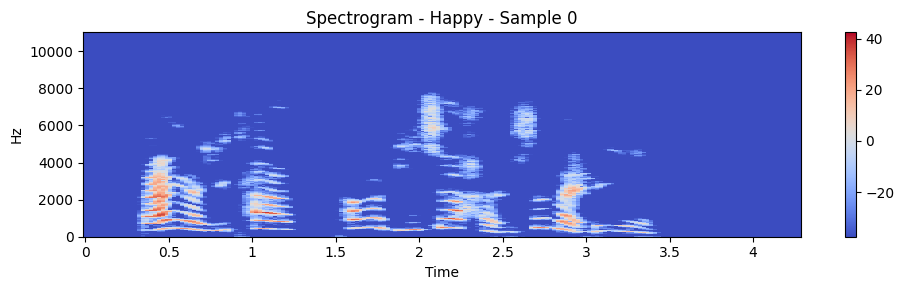

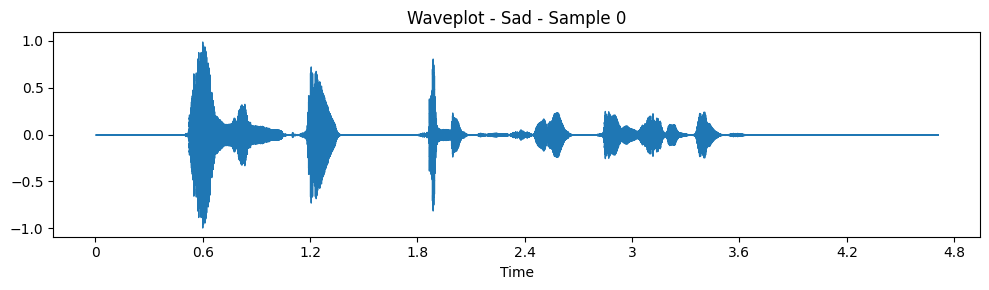

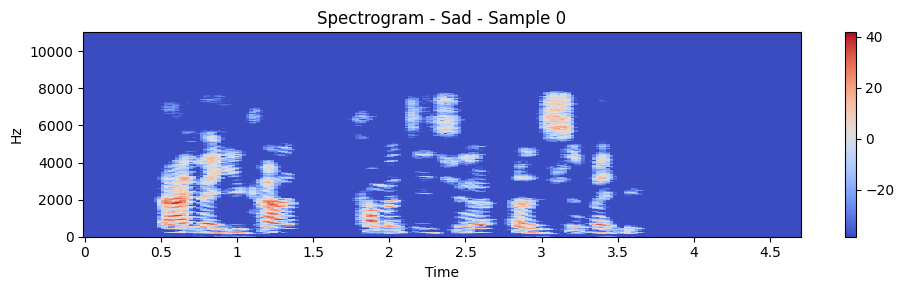

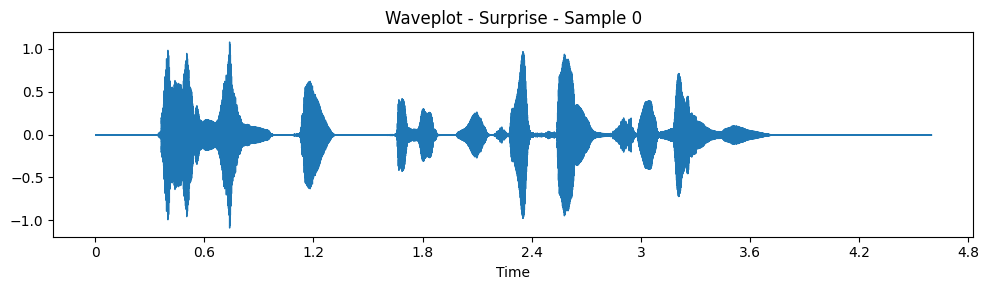

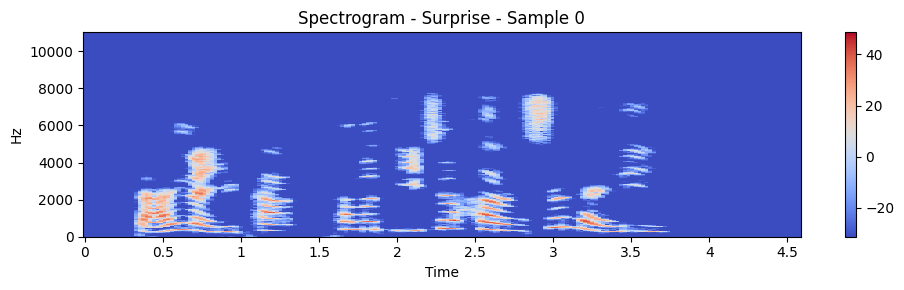

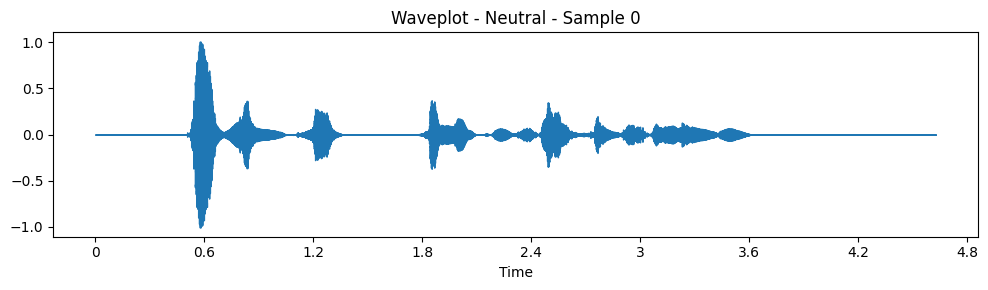

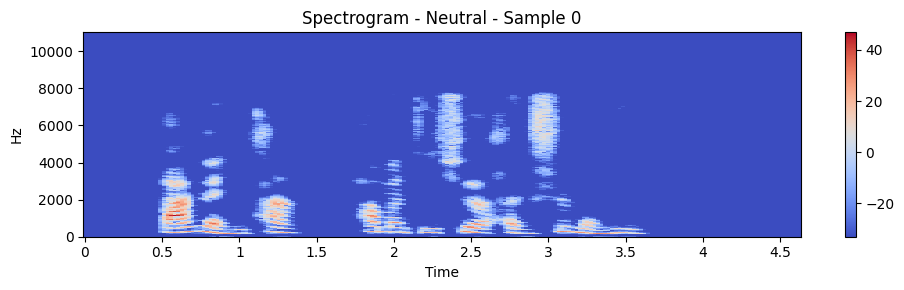

In [73]:
for emotion in dff.index:
    for idx in range(1):  # Change range to visualize more
        path = dff.loc[emotion, idx]
        if pd.notna(path):
            data, sr = librosa.load(path)
            create_waveplot(data, sr, emotion, idx)
            create_spectrogram(data, sr, emotion, idx)
            display(Audio(path))


## Feature Extraction
- Extraction of features is a very important part in analyzing and finding relations between different things. As we already know that the data provided of audio cannot be understood by the models directly so we need to convert them into an understandable format for which feature extraction is used.


The audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency.

![image.png](https://miro.medium.com/max/633/1*7sKM9aECRmuoqTadCYVw9A.jpeg)

I am no expert on audio signals and feature extraction on audio files so i need to search and found a very good blog written by [Askash Mallik](https://medium.com/heuristics/audio-signal-feature-extraction-and-clustering-935319d2225) on feature extraction.

As stated there with the help of the sample rate and the sample data, one can perform several transformations on it to extract valuable features out of it.
1. Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.
2. Energy : The sum of squares of the signal values, normalized by the respective frame length.
3. Entropy of Energy : The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.
4. Spectral Centroid : The center of gravity of the spectrum.
5. Spectral Spread : The second central moment of the spectrum.
6. Spectral Entropy :  Entropy of the normalized spectral energies for a set of sub-frames.
7. Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the two successive frames.
8. Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
9.  MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.
10. Chroma Vector : A 12-element representation of the spectral energy where the bins represent the 12 equal-tempered pitch classes of western-type music (semitone spacing).
11. Chroma Deviation : The standard deviation of the 12 chroma coefficients.


In this project i am not going deep in feature selection process to check which features are good for our dataset rather i am only extracting 5 features:
- Zero Crossing Rate
- Chroma_stft
- MFCC
- RMS(root mean square) value
- MelSpectogram to train our model.

In [74]:
def extract_features(path, sr=16000, n_mfcc=40):
    try:
        data, sr = librosa.load(path, sr=sr)
        mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=n_mfcc)
        mfccs_mean = np.mean(mfccs.T, axis=0)

        chroma = librosa.feature.chroma_stft(y=data, sr=sr)
        chroma_mean = np.mean(chroma.T, axis=0)

        contrast = librosa.feature.spectral_contrast(y=data, sr=sr)
        contrast_mean = np.mean(contrast.T, axis=0)

        zcr = librosa.feature.zero_crossing_rate(y=data)
        zcr_mean = np.mean(zcr)

        rms = librosa.feature.rms(y=data)
        rms_mean = np.mean(rms)

        # Combine all features into a single vector
        feature_vector = np.concatenate((mfccs_mean, chroma_mean, contrast_mean, [zcr_mean], [rms_mean]))
        return feature_vector

    except Exception as e:
        print(f"❌ Feature extraction failed for: {path} — {e}")
        return None


In [118]:
features = []
labels = []

for emotion in dff.index:
    for col in dff.columns:
        path = dff.loc[emotion, col]
        if pd.notna(path):
            feature_vector = extract_features(path)
            if feature_vector is not None:
                features.append(feature_vector)
                labels.append(emotion)

# Safety check
print("✅ Features:", len(features), "Labels:", len(labels))
assert len(features) == len(labels), "Mismatch in features and labels!"

# Convert to arrays
features_array = np.array(features)
labels_array = np.array(labels)

# Build dataframe
features_df = pd.DataFrame(features_array)
features_df['label'] = labels_array


✅ Features: 31500 Labels: 31500


In [119]:
print(features_df.shape)
print(len(labels_array))
print(len(features_array))

(31500, 62)
31500
31500


In [120]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31500 entries, 0 to 31499
Data columns (total 62 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       31500 non-null  float64
 1   1       31500 non-null  float64
 2   2       31500 non-null  float64
 3   3       31500 non-null  float64
 4   4       31500 non-null  float64
 5   5       31500 non-null  float64
 6   6       31500 non-null  float64
 7   7       31500 non-null  float64
 8   8       31500 non-null  float64
 9   9       31500 non-null  float64
 10  10      31500 non-null  float64
 11  11      31500 non-null  float64
 12  12      31500 non-null  float64
 13  13      31500 non-null  float64
 14  14      31500 non-null  float64
 15  15      31500 non-null  float64
 16  16      31500 non-null  float64
 17  17      31500 non-null  float64
 18  18      31500 non-null  float64
 19  19      31500 non-null  float64
 20  20      31500 non-null  float64
 21  21      31500 non-null  float64
 22

In [121]:
features_df.describe()

0             1             2             3             4   \
count  31500.000000  31500.000000  31500.000000  31500.000000  31500.000000   
mean    -452.265978     39.517686     -6.641430     -6.696137     -9.953222   
std       30.665883     11.872643     12.859037     10.228785      7.671106   
min     -592.606689    -14.407661    -52.763351    -44.428795    -42.924412   
25%     -473.526627     31.536641    -15.517624    -13.587793    -15.083108   
50%     -451.420105     39.476704     -6.837924     -7.052023    -10.090059   
75%     -430.547600     47.368995      2.148827      0.043773     -4.922734   
max     -345.085388     83.783630     46.793026     37.359203     34.895954   

                 5             6             7             8             9   \
count  31500.000000  31500.000000  31500.000000  31500.000000  31500.000000   
mean     -12.226303    -14.735942    -13.669816    -10.261419     -6.783933   
std        6.745843      6.227728      5.006144      4.725748      4.482188   
min      -41.947590    -43.739304    -34.541374    -29.207653    -26.823914   
25%      -16.711282    -18.924364    -16.945985    -13.495655     -9.788666   
50%      -12.129757    -14.585732    -13.618928    -10.404988     -6.928212   
75%       -7.700186    -10.439254    -10.319331     -7.161543     -3.885668   
max       13.720766      6.714454      8.806788      9.391951     18.942251   

       ...            51            52            53            54  \
count  ...  31500.000000  31500.000000  31500.000000  31500.000000   
mean   ...      0.182971     21.545178     20.416204     23.338756   
std    ...      0.050569      2.945496      2.646089      2.468822   
min    ...      0.018979     11.320086     10.916677     14.112256   
25%    ...      0.147937     19.434272     18.638462     21.669439   
50%    ...      0.181073     21.426643     20.328260     23.335860   
75%    ...      0.215938     23.471761     22.091951     24.982777   
max    ...      0.418039     33.605786     32.513374     33.745811   

                 55            56            57            58            59  \
count  31500.000000  31500.000000  31500.000000  31500.000000  31500.000000   
mean      22.601458     25.983719     26.328496     19.424138      0.115132   
std        2.782744      2.888997      2.956429      1.999262      0.030380   
min       12.627384     14.914012     15.827969     12.078396      0.023155   
25%       20.662845     23.983740     24.281962     18.012306      0.093710   
50%       22.451578     25.988169     26.288329     19.296617      0.113104   
75%       24.388654     27.982621     28.347691     20.713883      0.134631   
max       34.838951     36.020085     37.903838     28.391050      0.248638   

                 60  
count  31500.000000  
mean       0.048259  
std        0.014491  
min        0.013448  
25%        0.037281  
50%        0.046539  
75%        0.057346  
max        0.124028  

[8 rows x 61 columns]

In [122]:
features_df.isnull().sum()

0        0
1        0
2        0
3        0
4        0
        ..
57       0
58       0
59       0
60       0
label    0
Length: 62, dtype: int64

In [123]:
# As this is a multiclass classification problem onehotencoding our Y.
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


In [124]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.utils import to_categorical
         

# Encode and reshape
X = features_df.iloc[:, :-1].values
Y = features_df['label'].values

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Pad to square
num_features = X_scaled.shape[1]
side_len = int(np.ceil(np.sqrt(num_features)))
pad_width = side_len**2 - num_features
X_padded = np.pad(X_scaled, ((0, 0), (0, pad_width)), mode='constant')
X_reshaped = X_padded.reshape(-1, side_len, side_len, 1)

# Encode Y
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)
Y_onehot = to_categorical(Y_encoded)

print("X shape:", X_reshaped.shape)
print("Y shape:", Y_onehot.shape)
assert X_reshaped.shape[0] == Y_onehot.shape[0], "Mismatch in sample count!"


X shape: (31500, 8, 8, 1)
Y shape: (31500, 5)


In [129]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_reshaped, Y_onehot, test_size=0.2, random_state=42, stratify=Y_onehot)


In [135]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=X_reshaped.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(Y_onehot.shape[1], activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


d:\intern code aloha\ml\car\havenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [136]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 32)       │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,357 (204.52 KB)

 Trainable params: 52,357 (204.52 KB)

 Non-trainable params: 0 (0.00 B)

In [137]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history = model.fit(X_train, Y_train,epochs=30,batch_size=32,validation_data=(X_test, Y_test),verbose=1
)


Epoch 1/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.3485 - loss: 1.4360 - val_accuracy: 0.5381 - val_loss: 1.1166
Epoch 2/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.5030 - loss: 1.1656 - val_accuracy: 0.5997 - val_loss: 0.9885
Epoch 3/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.5526 - loss: 1.0716 - val_accuracy: 0.6408 - val_loss: 0.9213
Epoch 4/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.5777 - loss: 1.0242 - val_accuracy: 0.6513 - val_loss: 0.8837
Epoch 5/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6055 - loss: 0.9794 - val_accuracy: 0.6621 - val_loss: 0.8479
Epoch 6/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6049 - loss: 0.9629 - val_accuracy: 0.6868 - val_loss: 0.8037
Epoch 7/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6217 - loss: 0.9341 - val_accuracy: 0.6903 - val_loss: 0.7917
Epoch 8/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6364 - loss: 0.9074 - val_accuracy:

In [138]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,Y_test)[1]*100 , "%")

197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7436 - loss: 0.6367
Accuracy of our model on test data :  74.49206113815308 %


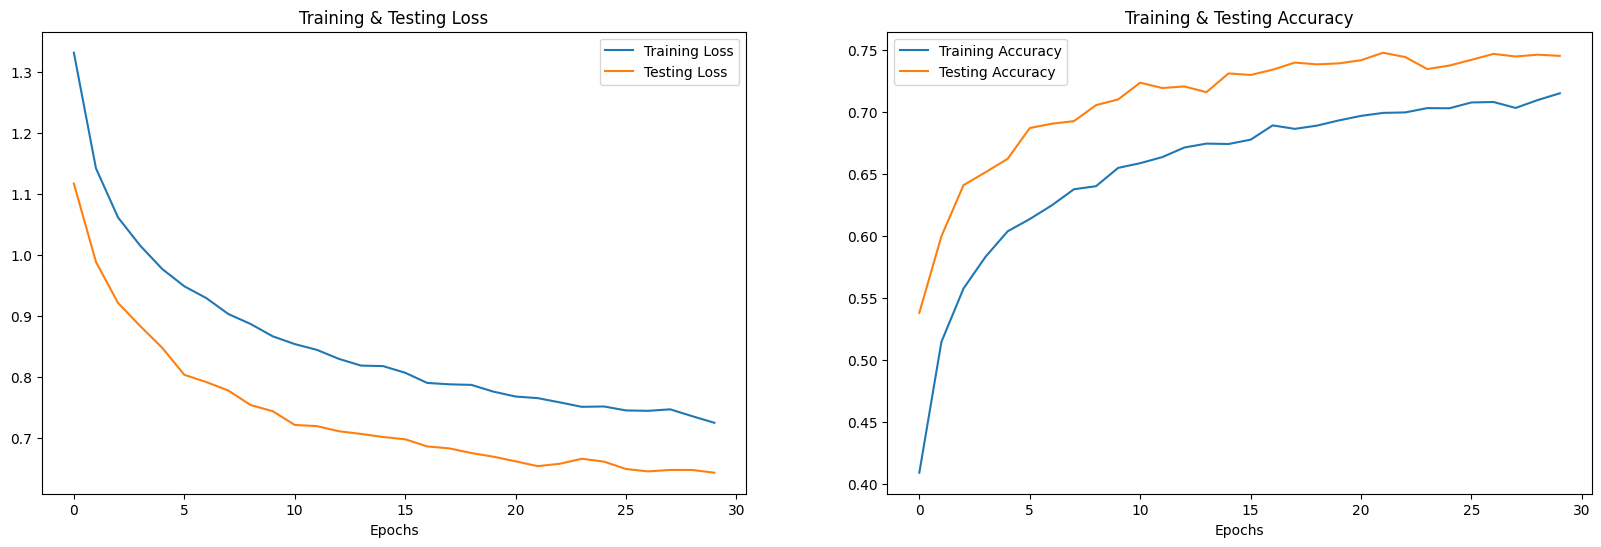

In [140]:
epochs = [i for i in range(30)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [141]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

197/197 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step
              precision    recall  f1-score   support

       Angry       0.67      0.80      0.73      1260
       Happy       0.70      0.60      0.65      1260
     Neutral       0.80      0.82      0.81      1260
         Sad       0.82      0.80      0.81      1260
    Surprise       0.73      0.70      0.72      1260

    accuracy                           0.74      6300
   macro avg       0.75      0.74      0.74      6300
weighted avg       0.75      0.74      0.74      6300



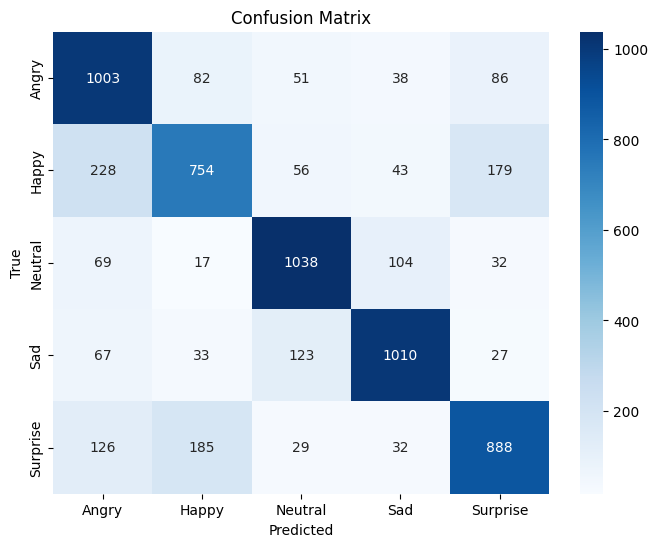

In [142]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix")
plt.show()

In [143]:
# Save model
model.save("emotion_recognition_model.h5")

# Save label encoder and scaler
import joblib
joblib.dump(label_encoder, "label_encoder.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [152]:
from pydub import AudioSegment
import os
import numpy as np

def predict_emotion(audio_path, model, scaler, label_encoder):
    # Step 1: Convert .mp3 to .wav if needed
    if audio_path.endswith('.mp3'):
        sound = AudioSegment.from_mp3(audio_path)
        audio_path = audio_path.replace(".mp3", ".wav")
        sound.export(audio_path, format="wav")

    # Step 2: Standardize audio and enhance (denoise + normalize)
    rate, data = standardize_audio_to_array(audio_path)
    cleaned_path = audio_path.replace(".wav", "_cleaned.wav")
    enhance_and_save(rate, data, cleaned_path)

    # Step 3: Extract features
    features = extract_features(cleaned_path)
    if features is None:
        return "Invalid or empty audio"

    # Step 4: Scale, pad, and reshape
    features_scaled = scaler.transform([features])
    padded = np.pad(features_scaled, ((0, 0), (0, pad_width)), mode='constant')
    reshaped = padded.reshape(-1, side_len, side_len, 1)

    # Step 5: Predict
    prediction = model.predict(reshaped)
    emotion = label_encoder.inverse_transform([np.argmax(prediction)])
    return emotion[0]


In [157]:
print(predict_emotion("D:\\intern code aloha\\ml\\car\\havenv\\Emotional Speech Dataset (ESD)\\Emotion Speech Dataset\\0015\\Happy\\0015_000709.wav",
    model,
    scaler,
    label_encoder
))


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
Happy
